Displaying 4 random patches...

--- Patch 1 ---
Actual deforestation area: 2.70%
Predicted deforestation area: 7.60%
Prediction confidence range: [0.000, 1.000]


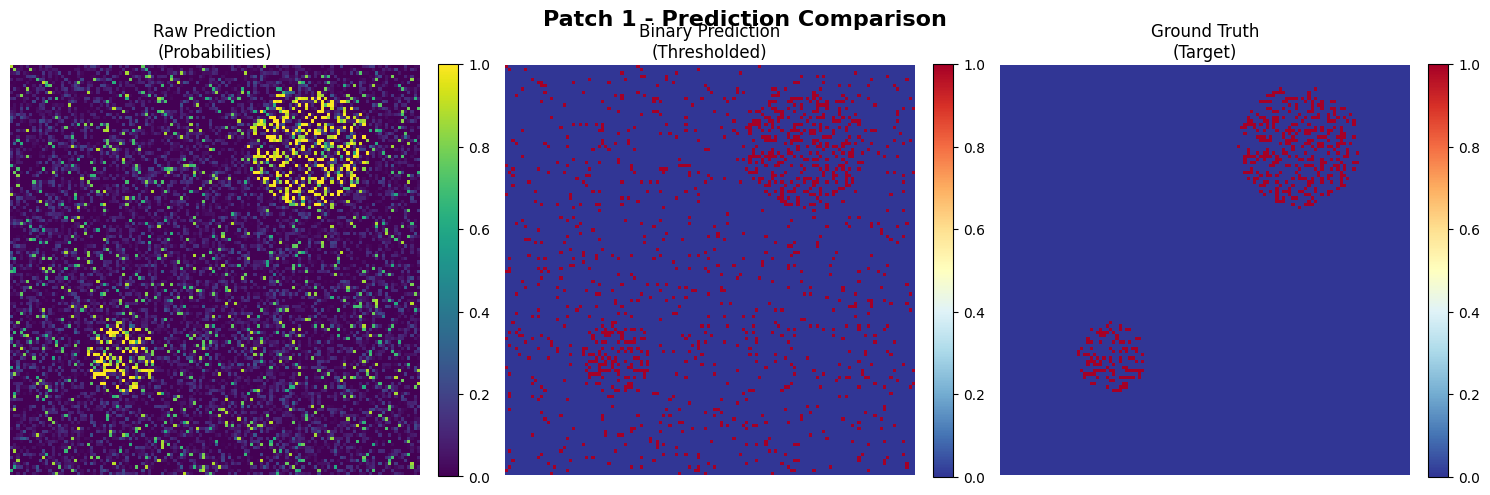


--- Patch 2 ---
Actual deforestation area: 2.83%
Predicted deforestation area: 6.96%
Prediction confidence range: [0.000, 1.000]


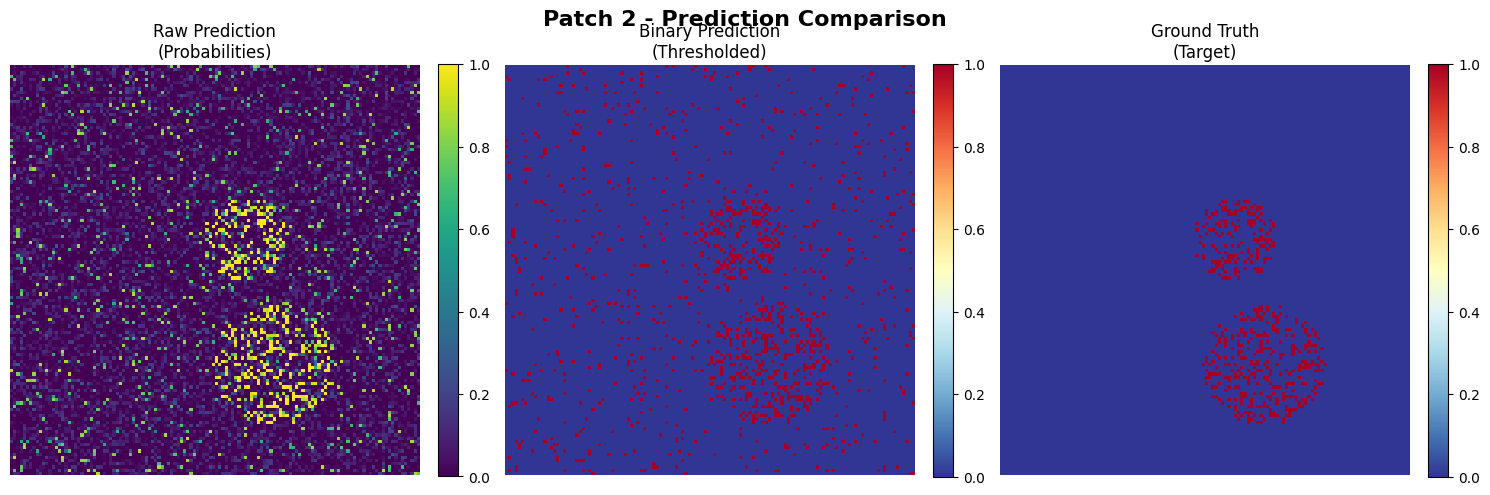


--- Patch 3 ---
Actual deforestation area: 10.05%
Predicted deforestation area: 12.85%
Prediction confidence range: [0.000, 1.000]


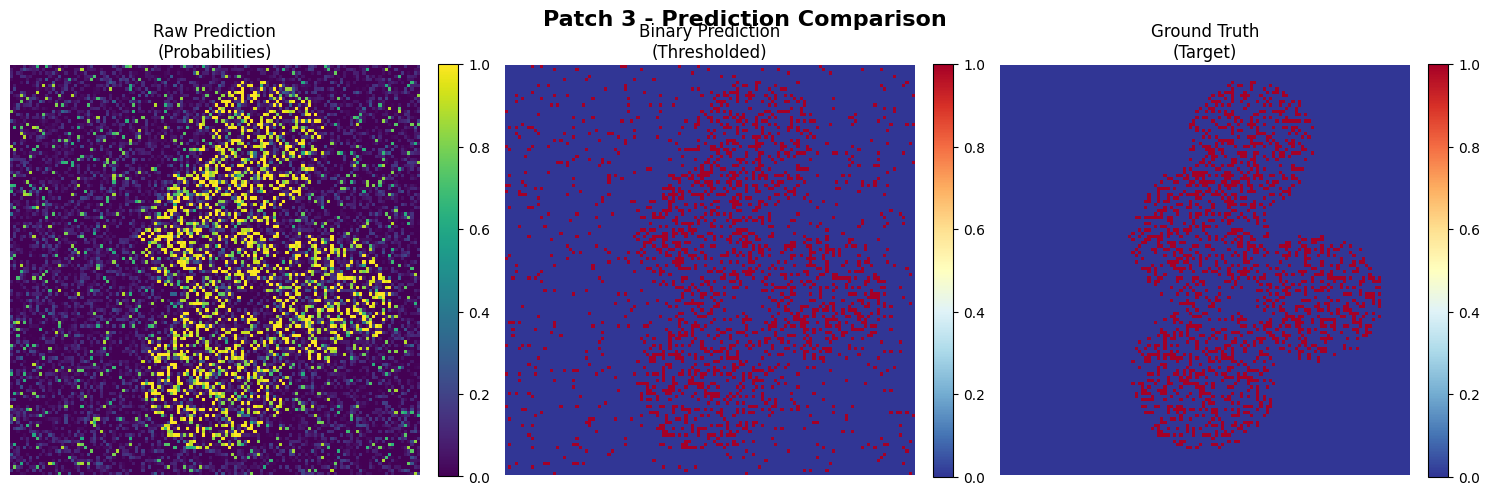


--- Patch 4 ---
Actual deforestation area: 2.93%
Predicted deforestation area: 7.24%
Prediction confidence range: [0.000, 1.000]


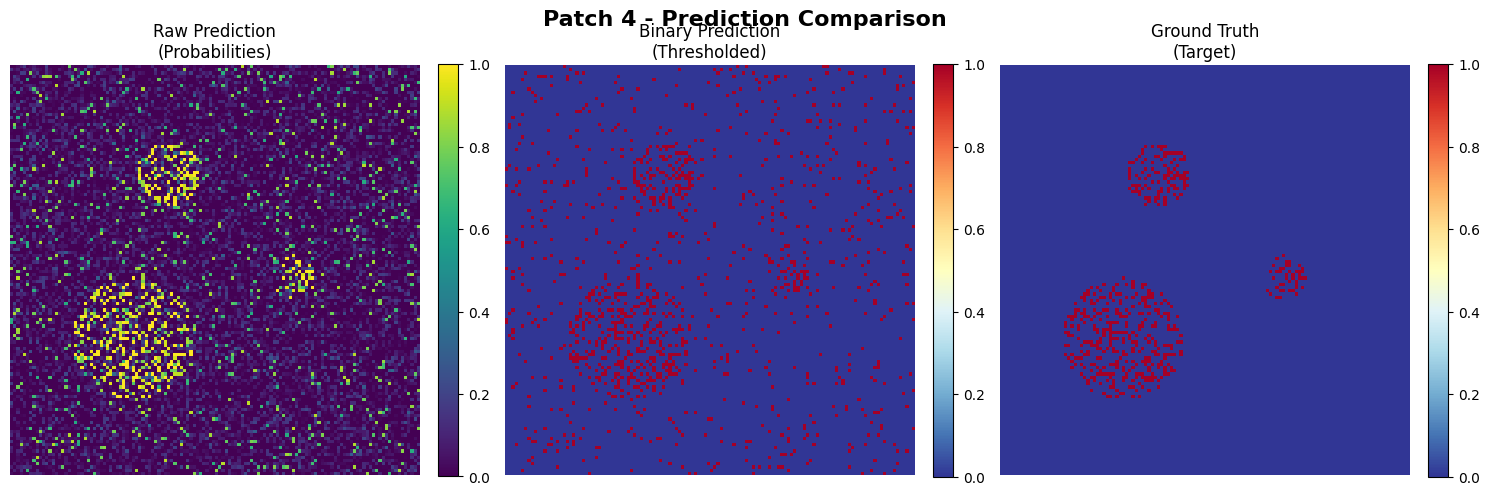

In [3]:
"""Display random patches for Amazon deforestation prediction."""

import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add src to path
sys.path.append(os.path.join(os.getcwd(), '..', 'src'))

from utils.amazon_plots import plot_prediction_patch

def create_sample_patch(patch_size=256, complexity=0.3):
    """Create a sample patch with deforestation patterns.
    
    Args:
        patch_size: Size of the patch (default: 256)
        complexity: Complexity of the deforestation pattern (0-1)
    
    Returns:
        tuple: (prediction, binary_prediction, target)
    """
    # Create target with realistic deforestation patterns
    target = np.zeros((patch_size, patch_size))
    
    # Add some random deforestation areas
    num_areas = int(np.random.uniform(1, 5))
    for _ in range(num_areas):
        center_x = np.random.randint(20, patch_size - 20)
        center_y = np.random.randint(20, patch_size - 20)
        radius = np.random.randint(5, 25)
        
        # Create irregular shapes
        y, x = np.ogrid[:patch_size, :patch_size]
        mask = (x - center_x)**2 + (y - center_y)**2 <= radius**2
        
        # Add some noise to make it more realistic
        noise = np.random.random((patch_size, patch_size)) > 0.7
        mask = mask & noise
        
        target[mask] = 1.0
    
    # Create prediction with some noise and uncertainty
    prediction = target.copy().astype(float)
    
    # Add prediction uncertainty
    prediction += np.random.normal(0, 0.1, prediction.shape)
    
    # Add some false positives and negatives
    false_positives = np.random.random((patch_size, patch_size)) > 0.95
    prediction[false_positives] = np.random.uniform(0.6, 0.9, np.sum(false_positives))
    
    false_negatives = (target == 1) & (np.random.random((patch_size, patch_size)) > 0.85)
    prediction[false_negatives] = np.random.uniform(0.1, 0.4, np.sum(false_negatives))
    
    # Clip to [0, 1] range
    prediction = np.clip(prediction, 0, 1)
    
    # Create binary prediction using threshold
    threshold = 0.5
    binary_prediction = (prediction > threshold).astype(float)
    
    return prediction, binary_prediction, target

def display_random_patches(num_patches=3, patch_size=256):
    """Display multiple random patches.
    
    Args:
        num_patches: Number of patches to display
        patch_size: Size of each patch
    """
    print(f"Displaying {num_patches} random patches...")
    
    for i in range(num_patches):
        print(f"\n--- Patch {i+1} ---")
        
        # Create sample patch
        prediction, binary_prediction, target = create_sample_patch(patch_size)
        
        # Display statistics
        deforestation_area = np.sum(target) / (patch_size * patch_size) * 100
        predicted_area = np.sum(binary_prediction) / (patch_size * patch_size) * 100
        
        print(f"Actual deforestation area: {deforestation_area:.2f}%")
        print(f"Predicted deforestation area: {predicted_area:.2f}%")
        print(f"Prediction confidence range: [{prediction.min():.3f}, {prediction.max():.3f}]")
        
        # Plot the patch
        plot_prediction_patch(
            prediction=prediction,
            binary_prediction=binary_prediction,
            target=target,
            patch_idx=i+1,
            figsize=(15, 5),
            show=True
        )

# Set random seed for reproducibility
np.random.seed(42)

# Display random patches
display_random_patches(num_patches=4, patch_size=128)
